# gini_lorenz_us_v10

In [1]:
import pandas as pd
import numpy as np
from numba import njit, prange
import quantecon as qe
import matplotlib.pyplot as plt
from itertools import takewhile
from scipy.integrate import simps
from IPython.core.display import display, HTML
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import itertools
from interpolation import interp
from scipy import interpolate

%matplotlib inline

# overview

Using database ``SCF_plus``, which is constructed by [Kuhn, Schularick and Steins (2020)](https://www.journals.uchicago.edu/doi/10.1086/708815), this notebook plots
- transitional labor income, total income and net wealth ginis for US
- lorenz curves for US total income and net wealth in year 2016

### Def. (General Gini coefficients)

For incomes/wealth of $x_i, \forall i=1, \cdots, n$ and them ranked in non-decreasing order, the covariance expression for the Gini, $G$, is ([Creedy 2015](https://www.wgtn.ac.nz/cpf/publications/pdfs/2015-pubs/WP03_2015_Gini_Inequality.pdf)):
$$
G = \frac{2 Cov (x, F(x)) }{ \bar x}
$$
where 
- $F(x)$ is the distribution function,
- $\bar x$ is the arithmetic mean of the $x_i$,
- $Cov (x, F(x))$ is the covariance.

## define some functions

In [2]:
def topshare(d, c=0.05, x='nw', fw='fw'):
    
    d = d[[x, fw]].sort_values(x, ascending=True).copy()
    
    d['xfw'] = d[x] * d[fw]
    d['Fw'] = d[fw].cumsum()
    
    n = min([index for index,value in enumerate(d['Fw']) if value > (1-c)])
    w = d['xfw']
    wt = w[n:-1]
    
    
    return np.sum(wt) / np.sum(w)

In [3]:
def plot_ginis(x, y, 
               plotlabel="total income gini", 
               ylabel="gini coefficient", 
               path='wgini_us.pdf'):
    
    fig, ax = plt.subplots()
    ax.plot(x, y, marker='o', label=plotlabel)

    ax.set_xlabel("year", fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)

    ax.legend(fontsize=12)
    plt.savefig(path)
    plt.show()

In [4]:
# @njit(parallel=True)
def gini_coefficient(d, x='nw', aw='wgtI95W95'):
    r"""
    Implements the Gini inequality index with analytical weights

    References
    ----------

    https://en.wikipedia.org/wiki/Gini_coefficient
    """
    
    d = d[[x, aw]].sort_values(x, ascending=True).copy()
    
    y = d[x]
    
    f_x = d[aw] / d[aw].sum()
    F_x = f_x.cumsum()
    
    mu = np.sum(y * f_x)
    
    cov = np.cov(y, F_x, rowvar=False, aweights=f_x)[0,1]
    
    return 2 * cov / mu

In [5]:
def lorenz(d, x='nw', fw='fw'):
    
    d = d[[x, fw]].sort_values(x, ascending=True).copy()
    
    
    d[x] = d[x] * d[fw]
    
    res = d.cumsum() / d.sum()
    
    return res[fw], res[x]

In [6]:
def lorenzit():
    return interp(x_s, y_s, x)

In [7]:
def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))

In [8]:
def get_lorenz(df, xname='nw'):
    
    f_vals, l_vals = [], []
    for i in df.groupby('yearmerge').apply(lorenz, x=xname):
        f_vals.append(np.asarray(i[0]))
        l_vals.append(np.asarray(i[1]))
        
    return f_vals, l_vals

In [9]:
def lorenz2gini1(y, x):
    """
    Measure the area using Trapezoidal rule 
    
    Please find here: https://numpy.org/doc/stable/reference/generated/numpy.trapz.html
    """
    return (0.5 - np.trapz(y, x=x)) / 0.5

In [10]:
def lorenz2gini2(y, x):
    """
    Measure the area using simpsons rule
    
    https://scipy.github.io/devdocs/tutorial/integrate.html#integrating-using-samples
    """
    return (0.5 - simps(y, x=x)) / 0.5

## import and process the data

The data is stored here: https://github.com/QuantEcon/high_dim_data/blob/main/SCF_plus/SCF_plus.dta?raw=true.

We can cross-check the following table with [Kuhn, Schularick and Steins (2020)](https://www.journals.uchicago.edu/doi/10.1086/708815)'s.

In [11]:
df = pd.read_stata('https://github.com/QuantEcon/high_dim_data/blob/main/SCF_plus/SCF_plus.dta?raw=true')
df = df[['id', 'year', 'ffanw', 'impnum', 'tinc', 'incws', 
         'yearmerge', 'wgtI95W95', 'ffanwgroups', 'tincgroups']]
df['nw'] = df['ffanw'] 
df['ti'] = df['tinc']
df['li'] = df['incws']
df1=df.astype({'yearmerge': int, 'year': int}).dropna()
df2 = df1.groupby('yearmerge').sum().reset_index()

# calculate variables with weights

df3 = df2[['yearmerge', 'wgtI95W95']]
df3.columns = 'yearmerge', 'fw'
df4 = pd.merge(df3, df1, how="left", on=["yearmerge"])
df4['fw'] = df4['wgtI95W95'] / df4['fw']
df4['nwfw'] = df4['nw'] * df4['fw']
df4['tifw'] = df4['ti'] * df4['fw']
df4['lifw'] = df4['li'] * df4['fw']

dfx_1 = df4.groupby('yearmerge').sum().reset_index()
df5 = df4[df4['ffanwgroups'] == 'Top 10%']
df6 = df4[df4['tincgroups'] == 'Top 10%']

dfx_2 = df5.groupby('yearmerge').sum().reset_index()
dfx_3 = df6.groupby('yearmerge').sum().reset_index()

dfx_1['nwfwtop10'] = dfx_2['nwfw']
dfx_1['tifwtop10'] = dfx_3['tifw']
dfx_1['lifwtop10'] = dfx_3['lifw']

dfx_1['nwfw'] = dfx_1['nwfwtop10'] / dfx_1['nwfw']
dfx_1['tifw'] = dfx_1['tifwtop10'] / dfx_1['tifw']
dfx_1['lifw'] = dfx_1['lifwtop10'] / dfx_1['lifw']
dfx_4 = dfx_1[['yearmerge', 'nwfw', 'tifw', 'lifw']]

df7 = df4.groupby('yearmerge').apply(gini_coefficient, x='nw').to_frame().reset_index()
df7.columns = 'yearmerge', 'nw'

df8 = df4.groupby('yearmerge').apply(gini_coefficient, x='ti').to_frame().reset_index()
df8.columns = 'yearmerge', 'ti'

df9 = df4.groupby('yearmerge').apply(gini_coefficient, x='li').to_frame().reset_index()
df9.columns = 'yearmerge', 'li'

df8['nw'] = df7['nw']
df8['li'] = df9['li']
df8['topnw'] = dfx_4['nwfw']
df8['topti'] = dfx_4['tifw']
df8['topli'] = dfx_4['lifw']

df8

,yearmerge,ti,nw,li,topnw,topti,topli
0,1950,0.442887,0.825467,0.537074,0.728481,0.344888,0.194463
1,1953,0.425954,0.805667,0.516405,0.716981,0.318291,0.208020
2,1956,0.452425,0.812515,0.541754,0.720734,0.342615,0.238985
3,1959,0.438263,0.796247,0.527094,0.699496,0.329404,0.242411
4,1962,0.444881,0.814602,0.534969,0.724429,0.334118,0.140910
5,1965,0.436888,0.788713,0.748102,0.688363,0.331124,0.140400
6,1968,0.428210,0.801978,0.536256,0.706939,0.318522,0.243205
7,1971,0.427249,0.791657,0.559171,0.688179,0.314425,0.215095
8,1977,0.461506,0.756274,0.569864,0.640513,0.350292,0.248622
9,1983,0.456792,0.775618,0.571856,0.662277,0.335159,0.263979


# Dynamic Gini coefficients plots

In [12]:
wg = np.asarray(df8['nw'])
topwg = np.asarray(df8['topnw'])
it = np.asarray(df8['ti'])
topit = np.asarray(df8['topti'])
li = np.asarray(df8['li'])
topli = np.asarray(df8['topli'])
years = df8['yearmerge']

## labor income ginis

Since values in 1965 are abnormal, we are going to smooth the curves by taking the average of Ginis/top shares in 1962 and 1968 as the values in 1965.

In [13]:
li_new = li
topli_new = topli # use the topli from interpolation in section 2.2.2 below

# take the average of Ginis/topshares in 1962 and 1968 for 1965

li_new[5] = (li[4] + li[6]) / 2
topli_new[5] = (topli[4] + topli[6]) / 2

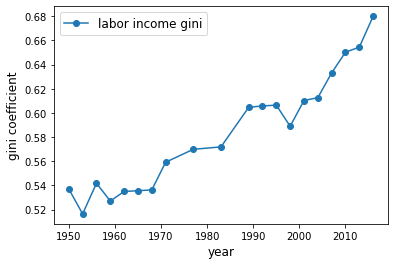

In [14]:
plot_ginis(years, li_new, 
           plotlabel="labor income gini", 
           ylabel="gini coefficient", 
           path='figures/gini_lorenz_us_1.pdf') # 2.13

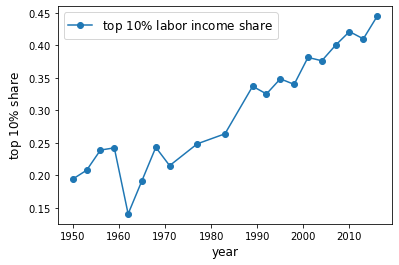

In [15]:
plot_ginis(years, topli_new,
           plotlabel="top $10\%$ labor income share", 
           ylabel="top $10\%$ share",
           path='figures/gini_lorenz_us_2.pdf') # 2.15

## net wealth ginis

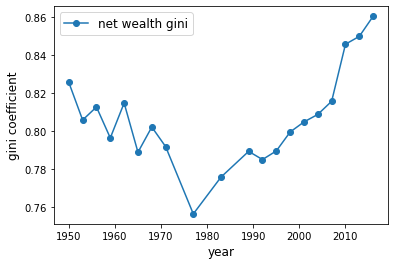

In [16]:
plot_ginis(years, wg,
           plotlabel="net wealth gini", 
           ylabel="gini coefficient", 
           path='figures/gini_lorenz_us_3.pdf') # 2.12

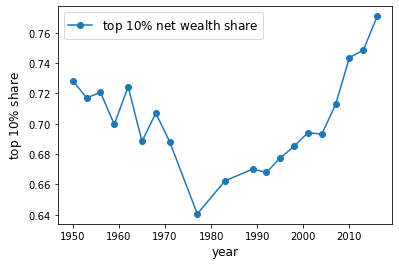

In [17]:
plot_ginis(years, topwg,
           plotlabel="top $10\%$ net wealth share", 
           ylabel="top $10\%$ share", 
           path='figures/gini_lorenz_us_4.pdf') # 2.14

## total income ginis

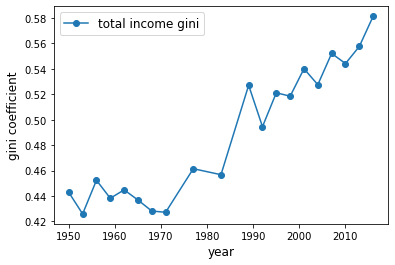

In [18]:
plot_ginis(years, 
           it, 
           plotlabel="total income gini", 
           ylabel="gini coefficient", 
           path='figures/gini_lorenz_us_6.pdf')

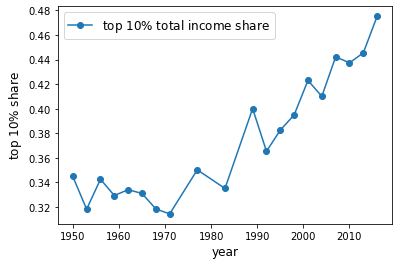

In [19]:
plot_ginis(years, 
           topit, 
           plotlabel="top $10\%$ total income share", 
           ylabel="top $10\%$ share", 
           path='figures/gini_lorenz_us_7.pdf')

We can cross-check plots of total income and net wealth with [Kuhn, Schularick and Steins (2020)](https://www.journals.uchicago.edu/doi/10.1086/708815)'s Figure 4 & 5.

# US lorenz curves: net wealth vs total income

## get lorenz curve data

In [20]:
xnames = ['nw', 'ti', 'li']
F = []
L = []
for xn in xnames:
    f_vals, l_vals = get_lorenz(df4, xname=xn)
    F.append(f_vals)
    L.append(l_vals)

f_val1, l_val1 = F[0][-1], L[0][-1]
f_val2, l_val2 = F[1][-1], L[1][-1]
f_val3, l_val3 = F[2][-1], L[2][-1]

fw = lambda x: interp(f_val1, l_val1, x)
fi = lambda x: interp(f_val2, l_val2, x)
fl = lambda x: interp(f_val3, l_val3, x)
x = np.linspace(0, 1, 100)

## plots

Then plot US Lorenz curves for net wealth and total income in year 2016.

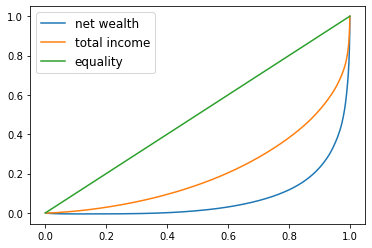

In [21]:
fig, ax = plt.subplots()

ax.plot(f_val1, l_val1, label=f'net wealth')
# ax.plot(f_val3, l_val3, label=f'labor income')
ax.plot(f_val2, l_val2, label=f'total income')
ax.plot(f_val1, f_val1, label='equality')

ax.legend(fontsize=12)
plt.savefig('figures/gini_lorenz_us_5.pdf')
plt.show()

## further cross-checking

Given [the following relationship between Lorenz curves and Gini index](https://en.wikipedia.org/wiki/Lorenz_curve#:~:text=This%20curve%20is%20called%20the,more%20unequal%20the%20distribution%20is.), we can also verify the US Lorenz curves with our estimated Gini coefficients above:
- The Gini coefficient is the ratio of the area between the line of perfect equality and the observed Lorenz curve to the area between the line of perfect equality and the line of perfect inequality.

In [22]:
wgini = []
igini = []
for f_val, l_val in zip(F[0], L[0]):
    wgini.append(lorenz2gini1(l_val, f_val))

for f_val, l_val in zip(F[1], L[1]):
    igini.append(lorenz2gini1(l_val, f_val))

df_lc = pd.DataFrame(list(zip(df8['yearmerge'], igini, wgini)), columns=['yearmerge', 'ti', 'nw'])
#display_side_by_side([df_lc, df8], ['Ginis From Lorenz', 'Ginis From Data'])

We cross-check our estimations again with the following 2 plots:
- we observed that the gini coefficients estimated from the Lorenz curves match perfectly with those estimated directly from data.

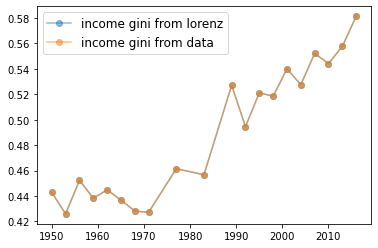

In [23]:
fig, ax = plt.subplots()
ax.plot('yearmerge', 'ti', data=df_lc, marker='o', alpha=0.5, label=f'income gini from lorenz')
ax.plot('yearmerge', 'ti', data=df8, marker='o', alpha=0.5, label=f'income gini from data')

ax.legend(fontsize=12)
plt.show()

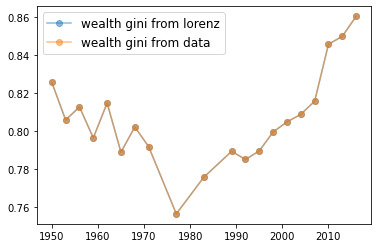

In [24]:
fig, ax = plt.subplots()
ax.plot('yearmerge', 'nw', data=df_lc, marker='o', alpha=0.5, label=f'wealth gini from lorenz')
ax.plot('yearmerge', 'nw', data=df8, marker='o', alpha=0.5, label=f'wealth gini from data')

ax.legend(fontsize=12)
plt.show()